In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,85)
        self.fc3 = nn.Linear(85,10)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 85)
  (fc3): Linear (85 -> 10)
)


In [2]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


In [3]:
input = Variable(torch.randn(1,1,32,32))
out = net(input)
print(out)

Variable containing:
 0.0898  0.0601 -0.1383 -0.0250  0.0790 -0.0222 -0.0951 -0.1217  0.0449 -0.1810
[torch.FloatTensor of size 1x10]



In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

In [5]:
transform = transforms.Compose([transforms.Pad(2),
                                transforms.ToTensor(),                            
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.MNIST(root='../datasets/',
                                      train=True,
                                      download=True,
                                      transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=2)

Processing...
Done!


In [6]:

testset = torchvision.datasets.MNIST(root="../datasets/",
                                    train=False,
                                    download=True,
                                    transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4,
                                         shuffle=False, 
                                         num_workers=2)

In [7]:
classes = tuple([str(x) for x in range(10)])

In [8]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(trainloader)
images, labels = dataiter.next()

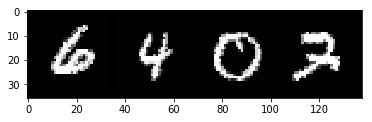

    6     4     0     3


In [9]:
plt.imshow(np.transpose(torchvision.utils.make_grid(images).numpy(),(1,2,0)))
plt.show()
print(" ".join("%5s" % classes[labels[j]] for j in range(4)))

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
for epoch in range(4):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20000))
            running_loss = 0.0
            
print("finished training")

[1,  2000] loss: 0.103
[1,  4000] loss: 0.021
[1,  6000] loss: 0.015
[1,  8000] loss: 0.011
[1, 10000] loss: 0.010
[1, 12000] loss: 0.009
[1, 14000] loss: 0.008
[2,  2000] loss: 0.007
[2,  4000] loss: 0.007
[2,  6000] loss: 0.006
[2,  8000] loss: 0.006
[2, 10000] loss: 0.006
[2, 12000] loss: 0.005
[2, 14000] loss: 0.005
[3,  2000] loss: 0.004
[3,  4000] loss: 0.004
[3,  6000] loss: 0.005
[3,  8000] loss: 0.004
[3, 10000] loss: 0.004
[3, 12000] loss: 0.005
[3, 14000] loss: 0.005
[4,  2000] loss: 0.003
[4,  4000] loss: 0.003
[4,  6000] loss: 0.003
[4,  8000] loss: 0.004
[4, 10000] loss: 0.003
[4, 12000] loss: 0.004
[4, 14000] loss: 0.004
finished training


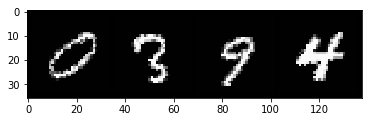

    0     3     9     4


In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.imshow(np.transpose(torchvision.utils.make_grid(images).numpy(),(1,2,0)))
plt.show()
print(" ".join("%5s" % classes[labels[j]] for j in range(4)))

In [13]:
outputs = net(Variable(images))

In [14]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join(str(predicted[j])
                              for j in range(4)))

Predicted:  0 3 9 4


In [15]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 99 %
Accuracy of     5 : 99 %
Accuracy of     6 : 98 %
Accuracy of     7 : 98 %
Accuracy of     8 : 97 %
Accuracy of     9 : 97 %
